In [1]:
import os, glob, pickle, json, time
from PIL import Image, ImageDraw
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torch.amp import autocast, GradScaler
from tqdm import tqdm

import json # Needed for loading annotations
import time # Needed for the load_annotations retry logic
import cv2  # Needed for warp_roi
import glob # Needed to find pkl files

In [2]:
# — 경로 설정 및 어노테이션 로드 —
from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = '/content/drive/MyDrive/pt_data'
WEIGHTS_PATH = os.path.join(DATA_ROOT, 'model_weights/')

AIHUB_ANN = os.path.join(DATA_ROOT, 'aihub_annotations.json')
RDD_ANN   = os.path.join(DATA_ROOT, 'rdd2022_train_annotations.json')


Mounted at /content/drive


In [3]:
def load_and_consolidate_annotations(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    consolidated = {}
    if isinstance(data, list):
        for item in data:
            fn = item.get('file_name')
            if not fn: continue
            base = os.path.splitext(fn)[0]
            consolidated[base] = item
    elif isinstance(data, dict):
        # 이미 dict 형태일 때도 key 처리
        for fn, item in data.items():
            base = os.path.splitext(fn)[0]
            consolidated[base] = item
        for item in data.get('annotations', []):
            fn = item.get('file_name')
            if not fn: continue
            base = os.path.splitext(fn)[0]
            consolidated[base] = item
    return consolidated

In [4]:
# Load and consolidate annotations from both files
aihub_ann_dict = load_and_consolidate_annotations(AIHUB_ANN)
rdd_ann_dict   = load_and_consolidate_annotations(RDD_ANN)

# Combine the two dictionaries
ann_dict = {**aihub_ann_dict, **rdd_ann_dict}

In [5]:
# — 파일 목록 준비 —
train_pkls = glob.glob(os.path.join(DATA_ROOT, 'AIhub_Road',    'training_image_batch_*.pkl')) + \
             glob.glob(os.path.join(DATA_ROOT, 'RDD2022',        'training_image_batch_*.pkl'))
val_pkls   = glob.glob(os.path.join(DATA_ROOT, 'AIhub_Road',    'validation_image_batch_*.pkl')) + \
             glob.glob(os.path.join(DATA_ROOT, 'RDD2022',        'validation_image_batch_*.pkl'))

In [6]:
from albumentations.augmentations.crops.transforms import CropNonEmptyMaskIfExists as cropnoemptymaskifexists

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# — 트랜스폼 정의 —
seg_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [11]:
def get_deeplab_model(num_classes):
    model = deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, num_classes)
    #aspp = model.classifier[0]
    #aspp.pool = nn.Sequential(
    #    nn.AdaptiveAvgPool2d(1),
    #    nn.Conv2d(2048, 256, 1, bias=False),
    #    nn.GroupNorm(num_groups=32, num_channels=256),
    #    nn.ReLU()
    #)
    return model

In [19]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler    = GradScaler()
criterion = torch.nn.CrossEntropyLoss()

<ipython-input-19-ccee1c1995cc>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


In [14]:
crop_fn = cropnoemptymaskifexists(height=224, width=224)

In [17]:
def visualize_predictions(
    model,
    pkls,
    ann_dict,
    seg_tf,
    create_mask_binary,
    device,
    num_samples=10
):
    model.eval()
    samples = []
    for pklf in pkls:
        batch = pickle.load(open(pklf, 'rb'))
        for entry in batch:
            fn = entry['filename']
            arr = entry['image']
            anns = ann_dict.get(fn, {}).get('annotations', [])
            gt_mask = create_mask_binary(anns, arr.shape[:2])
            if not gt_mask.any():
                continue
            rgb = arr[..., ::-1]
            samples.append((rgb, gt_mask))
    samples = random.sample(samples, min(num_samples, len(samples)))

    cmap = ListedColormap([
        (0, 0, 0, 0),
        (1, 0, 0, 0.5),
    ])

    fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4 * len(samples)))
    for i, (rgb, gt_mask) in enumerate(samples):
        ax0 = axes[i, 0] if len(samples) > 1 else axes[0]
        ax0.imshow(rgb.astype('uint8'))
        ax0.set_title('Original Image')
        ax0.axis('off')

        ax1 = axes[i, 1] if len(samples) > 1 else axes[1]
        ax1.imshow(rgb.astype('uint8'))
        ax1.imshow(gt_mask, cmap=cmap, vmin=0, vmax=1, alpha=0.5)
        gt_labels = np.unique(gt_mask).tolist()
        ax1.set_title(f'GT Mask\nlabels: {gt_labels}')
        ax1.axis('off')

        img_t = seg_tf(Image.fromarray(rgb.astype(np.uint8))).unsqueeze(0).to(device)
        with torch.no_grad(), autocast():
            out = model(img_t)['out']
        pred_mask = out.argmax(dim=1).squeeze(0).cpu().numpy()

        ax2 = axes[i, 2] if len(samples) > 1 else axes[2]
        ax2.imshow(rgb.astype('uint8'))
        ax2.imshow(pred_mask, cmap=cmap, vmin=0, vmax=1, alpha=0.5)
        pred_labels = np.unique(pred_mask).tolist()
        ax2.set_title(f'Pred Mask\nlabels: {pred_labels}')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [20]:
testmodel = get_deeplab_model(2)
testmodel.to(device)
testmodel.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [24]:
testmodel.load_state_dict(torch.load(WEIGHTS_PATH+'deeplabv3_ep20.pth', map_location=device))

<All keys matched successfully>

<ipython-input-17-17f276d84899>:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pklf, 'rb'))
<ipython-input-17-17f276d84899>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


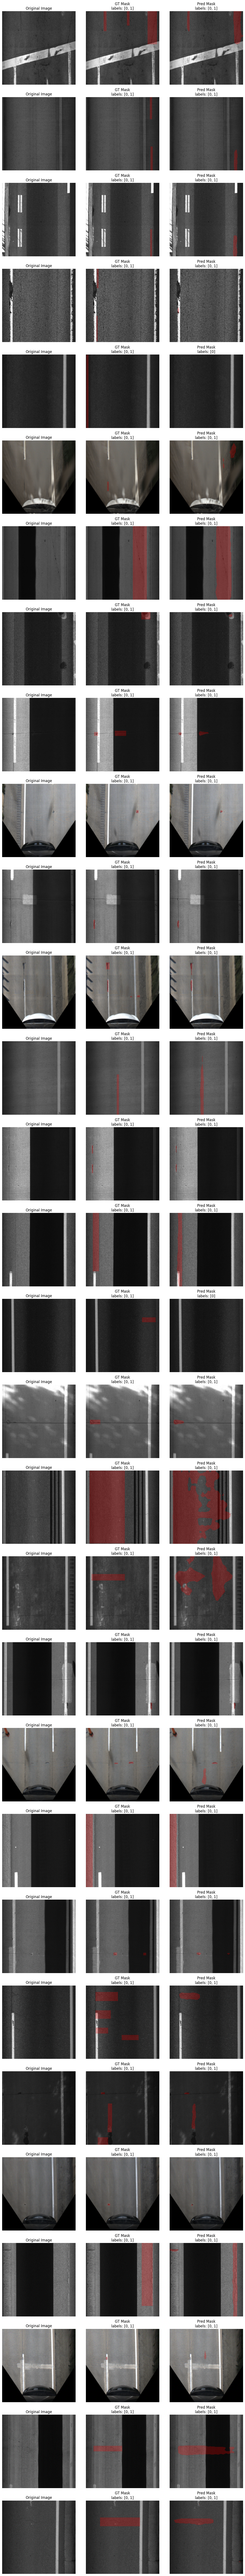

In [26]:

visualize_predictions(
    model=testmodel,
    pkls=val_pkls,
    ann_dict=ann_dict,
    seg_tf=seg_tf,
    create_mask_binary=create_mask_binary,
    device=device,
    num_samples=30
)

In [27]:
def count_val_false_negatives(
    pkls,
    ann_dict,
    seg_tf,
    create_mask_binary,
    model,
    device
):
    import pickle
    from PIL import Image
    import numpy as np
    import torch
    from torch.cuda.amp import autocast

    model.eval()
    no_pred = 0
    has_pred = 0
    for pkl_path in pkls:
        batch = pickle.load(open(pkl_path, 'rb'))
        for entry in batch:
            fn = entry['filename']
            arr = entry['image']
            gt_mask = create_mask_binary(
                ann_dict.get(fn, {}).get('annotations', []),
                arr.shape[:2]
            )
            if not gt_mask.any():
                continue
            img_rgb = arr[..., ::-1].astype(np.uint8)
            img_t = seg_tf(Image.fromarray(img_rgb)).unsqueeze(0).to(device)
            with torch.no_grad(), autocast():
                out = model(img_t)['out']
            pred_mask = out.argmax(dim=1).squeeze(0).cpu().numpy()
            if not pred_mask.any():
                no_pred += 1
            else:
                has_pred += 1
    print(f"GT 존재, Pred 없음: {no_pred}")
    print(f"GT 존재, Pred 있음: {has_pred}")

In [28]:
count_val_false_negatives(
    val_pkls=val_pkls,
    ann_dict=ann_dict,
    seg_tf=seg_tf,
    create_mask_binary=create_mask_binary,
    model=testmodel,
    device=device
)

<ipython-input-27-daad66a79323>:19: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pkl_path, 'rb'))
<ipython-input-27-daad66a79323>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


GT 존재, Pred 없음: 777
GT 존재, Pred 있음: 13449


In [29]:
count_val_false_negatives(
    val_pkls=train_pkls,
    ann_dict=ann_dict,
    seg_tf=seg_tf,
    create_mask_binary=create_mask_binary,
    model=testmodel,
    device=device
)

<ipython-input-27-daad66a79323>:19: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pkl_path, 'rb'))
<ipython-input-27-daad66a79323>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


GT 존재, Pred 없음: 6073
GT 존재, Pred 있음: 107366
